In [1]:
import librosa as lb
import numpy as np
import matplotlib.pyplot as plt
import time
import pyaudio

%matplotlib inline

In [6]:
!pip3 install pyaudio pyrtlsdr

You are using pip version 18.1, however version 20.0.2 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [13]:
import rtlsdr
rtlsdr.__file__
#sdr = rtlsdr.RtlSdr()

ImportError: Error loading librtlsdr. Make sure librtlsdr (and all of its dependencies) are in your path

In [1]:
f"{True}"

'True'

In [ ]:
# 1. use gnuradio to create FM receiver data
# 2. train a classifier model using labeled radio recordings
# 3. classify FM radio using classifier model
# 4. mute radio whenever model predicts the audio is playing an ad

# rtl_fm.exe -M fm -s 200k -A fast -r 48k -l 0 -E deemph -f 90.3M | "C:\Program Files (x86)\sox-14-4-1\sox.exe" -V1 -b 16 -c 1 -e signed-integer -r 48k -t raw - -t waveaudio default

In [2]:
import pyaudio
import wave
import time
import sys

p = pyaudio.PyAudio()
info = p.get_host_api_info_by_index(0)
numdevices = info.get('deviceCount')
for i in range(0, numdevices):
    if (p.get_device_info_by_host_api_device_index(0,i).get('maxInputChannels')) > 0:
        print(f"Input device id: {i} - {p.get_device_info_by_host_api_device_index(0, i).get('name')}")
print(numdevices)

Input device id: 0 - Microsoft Sound Mapper - Input
Input device id: 1 - Microphone (4- USB Advanced Aud
Input device id: 2 - Microphone (HD Webcam C310)
Input device id: 3 - CABLE Output (VB-Audio Virtual 
9


In [3]:
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 44100
CHUNK = 1024 * 100

import librosa as lb
import numpy as np
import matplotlib.pyplot as plt
import librosa.display

%matplotlib inline
def input_device_stft(deviceno):
    stream = p.open(format=FORMAT, channels=CHANNELS, rate=RATE, input=True, frames_per_buffer=CHUNK, input_device_index=deviceno)
    i = 0
    
    while i < 10:
        data = np.fromstring(stream.read(CHUNK), dtype=np.int16).astype(np.float16)
        print(type(data))
        
        X = lb.core.stft(data)
        lb.display.specshow(lb.amplitude_to_db(X, ref=np.max),
                           y_axis='log', x_axis='time')
        plt.tight_layout()
        plt.show()
        i+=1

#input_device_stft(2)

In [137]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import *
from sklearn.preprocessing import StandardScaler
import sklearn.preprocessing
import scipy.signal
import glob
import IPython.display as ipd
import csv
import pyaudio
import wave
import time
import sys
import librosa as lb
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import collections

from keras.models import Sequential
from keras.layers.core import *
from keras.layers import *
from keras.utils import to_categorical

class RadioModel:
    def __init__(self, radio_source):
        # music currently playing? -> 0
        # advertisement currently playing? -> 1
        # unsure? -> 2
        self.state = 0
        self.radio_source = radio_source
        self.neighbor_model = KNeighborsClassifier(weights='distance')
        self.sgd_model = SGDClassifier(penalty='l2', class_weight='balanced',loss='log')
        self.model = None
    
    def train(self, annotated_samples):
        feats_matrix = []
        labels = []
        for audio_sample, label in annotated_samples:
            feats, mapping = self.extract_features(audio_sample)
            for t in range(len(feats.T)):
                feats = feats.T[t]
                feats_matrix.append(feats)
                labels.append(label)
            #feats_matrix.append(feats)
            #labels.append(label)
        print(labels)
        self.neighbor_model.fit(feats_matrix, labels)
        self.model = self.neighbor_model
    
    def knn_train(self):
        self.neighbor_model.fit(self.X, self.y)
        self.model=self.neighbor_model
    
    def load_dataset(self):
        location = "./dataset/"
        list_annotated_samples = []
        for wav in glob.glob(location + "*.wav"):
            
            csv = wav[:-4] + ".csv"
            list_annotated_samples.append(self.annotated_samples(wav, csv))
            print(f"loading.. {wav}")
        self.list_annotated_samples = list_annotated_samples
        
        
        feats_matrix = []
        labels = []
        for annotated_sample in list_annotated_samples:
            for audio_sample, label in annotated_sample:
                feats_x_t, mapping = self.extract_features(audio_sample)
                for t in range(len(feats_x_t.T)):
                    feat = feats_x_t.T[t]
                    feats_matrix.append(feat)
                    labels.append(label)
                #feats_matrix.append(feats)
                #labels.append(label)
        print(labels)
        print("loaded dataset")
        self.X = feats_matrix.copy()
        self.scaler = StandardScaler()
        self.scaler.fit(self.X)
        self.X = self.scaler.transform(self.X)
        self.y = labels.copy()
        
    
    def sgd_train(self):
        self.sgd_model = SGDClassifier(penalty='l2', class_weight='balanced',loss='log')
        #self.scaler = StandardScaler()
        #self.scaler.fit(self.X)
        #self.X = self.scaler.transform(self.X)
        self.sgd_model.fit(self.X, self.y)
        self.model=self.sgd_model
    
    def cv_sgd_train(self):
        self.cv_sgd_model = SGDClassifier()
        self.param_grid = {'alpha': 10.0**-np.arange(1,3), 'penalty':['elasticnet', 'l1', 'l2'], 'loss': ['log', 'hinge'], 'class_weight':['balanced', None]}
        #self.scaler = StandardScaler()
        #self.scaler.fit(self.X)
        #self.X = self.scaler.transform(self.X)
        self.sgd_gridsearch_cv = GridSearchCV(self.cv_sgd_model, self.param_grid, cv=5, n_jobs=-1)
        self.sgd_gridsearch_cv.fit(self.X, self.y)
        
        print(f"best performing params: {self.sgd_gridsearch_cv.best_params_}")
        print(self.sgd_gridsearch_cv.cv_results_)
        self.model = self.sgd_gridsearch_cv.best_estimator_
    
    def cv_train(self):
        
        self.neighbor_model = KNeighborsClassifier(weights='distance')
        self.param_grid = {'n_neighbors': range(1, 25)}
        self.knn_gridsearch_cv = GridSearchCV(self.neighbor_model, self.param_grid, cv=5, n_jobs=-1)
        self.knn_gridsearch_cv.fit(self.X, self.y)
        
        print(f"best performing k: {self.knn_gridsearch_cv.best_params_}")
        print(self.knn_gridsearch_cv.cv_results_)
        self.model = self.knn_gridsearch_cv.best_estimator_
    
    def rnn_train(self):
        self.y_onehot = to_categorical([{'music': 0, 'ad':1, 'noise': 2}[label] for label in self.y], num_classes=3)
        self.y = self.y_onehot
        self.rnn = Sequential()
        layers = [256, 256, 64, 64, 3] # last layer is num labels
        self.rnn.add(Dropout(0.1, input_shape=(self.row_size,)))
        self.rnn.add(Dense(layers[0]))
        self.rnn.add(Activation('relu'))
        self.rnn.add(Dense(layers[1]))
        self.rnn.add(Activation('relu'))
        self.rnn.add(Dense(layers[2]))
        self.rnn.add(Activation('relu'))
        self.rnn.add(Dense(layers[3]))
        self.rnn.add(Dropout(0.5))
        self.rnn.add(Activation('relu'))
        self.rnn.add(Dropout(0.8))
        
        self.rnn.add(Dense(layers[-1]))
        self.rnn.add(Activation('softmax'))
        
        self.rnn.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
        self.rnn.fit(self.X, self.y, batch_size=100, epochs=20, validation_split=0.3)
        self.model = self.rnn
    
    def lstm_train(self):
        #self.labels_to_integers()
        self.y_onehot = to_categorical([{'music': 0, 'ad':1, 'noise': 2}[label] for label in self.y], num_classes=3)
        self.lstm = Sequential()
        self.batch_size = 300
        num_frames = 30
        self.X_seq = np.array([self.X[i: i+num_frames] for i in range(self.X.shape[0]-num_frames)])
        #self.X_seq = self.X_seq.reshape(1, self.X_seq.shape[1], self.row_size)
        self.y_seq = np.array([self.y_onehot[i: i+num_frames] for i in range(self.y_onehot.shape[0]-num_frames)])
        #self.y_seq = self.y_seq.reshape(1, self.y_seq.shape[1], 1)
        #self.lstm.add(layers.Embedding(input_dim = self.row_size, output_dim = 256))
        self.lstm.add(LSTM(units=2048, input_shape=(num_frames, self.X.shape[1]), return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
        self.lstm.add(TimeDistributed(Dense(2048, activation='relu')))
        self.lstm.add(TimeDistributed(Dense(1024, activation='relu')))
        self.lstm.add(Flatten())
        self.lstm.add(Dense(512, activation='relu'))
        self.lstm.add(Dense(128, activation='relu'))
        self.lstm.add(Dense(64, activation='relu'))
        self.lstm.add(Dense(32, activation='relu'))
        self.lstm.add(Dropout(0.5))
        self.lstm.add(Dense(3, activation='softmax'))
        
        self.lstm.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
        self.lstm.fit(self.X_seq, self.y_onehot[num_frames:], batch_size=self.batch_size, epochs=5, validation_split=0.2, shuffle=True)
        self.model = self.lstm
        
    def labels_to_integers(self):
        self.y_int = np.array([{'music': 0, 'ad': 1, 'noise': 2}[label] for label in self.y])
    
    def predict_sample(self, audio_sample, probs=False, lstm=False):
        if lstm==False:
            feats_matrix = []
            preds = []
            proba = []
            feats, mapping = self.extract_features(audio_sample)
            for t in range(len(feats.T)):
                feat = feats.T[t]
                feat = feat.reshape(1,-1)
                feat = self.scaler.transform(feat)
                preds.append(self.model.predict(feat))
                if probs: proba.append(self.model.predict_proba(feat))
            return preds, proba
        else:
            feats_matrix = []
            preds = []
            proba = []
            feats, mapping = self.extract_features(audio_sample)
            feats_seqs = []
            num_frames = 30
            #feats_seq = np.array([[self.scaler.transform(feat) for feat in feats.T[i-50: i]] for i in range(50, feats.T.shape[0])])
            print(f"len audio_sample_feats.shape: {feats.shape}")
            for i in range(len(feats.T) - num_frames):
                feat_seq = feats.T[i:i+num_frames]
                feat_seq = np.vstack(([self.scaler.transform(feat.reshape(1,-1)) for feat in feat_seq]))
                feat_seq = np.array(feat_seq)
                preds.append(self.model.predict(feat_seq.reshape(1,feat_seq.shape[0],feat_seq.shape[1]), batch_size=1))
#             for t, feat_seq in enumerate(feats_seq):
#                 preds.append(self.model.predict(feat_seq, batch_size=1))
                
            return preds, proba
    
    def predict_live(self, deviceno=3, probs=False, onehot=False, lstm=False):
        
        FORMAT = pyaudio.paInt16
        CHANNELS = 1
        RATE = 44100
        CHUNK = 1024 * 100
        p = pyaudio.PyAudio()
        stream = p.open(format=FORMAT, channels=CHANNELS, rate=RATE, input=True, frames_per_buffer=CHUNK, input_device_index=deviceno)
        print(f"Analyzing input from {p.get_device_info_by_host_api_device_index(0, deviceno).get('name')}")
        i = 0
        while True:
            
            data = np.frombuffer(stream.read(CHUNK), dtype=np.int16)
            data = scipy.signal.resample_poly(data, up=22050, down=44100)
            if i%2 == 0:
                X = lb.core.stft(data, hop_length=512)
                lb.display.specshow(lb.core.amplitude_to_db(np.abs(X)), y_axis='log', x_axis='time')
                plt.show()
                feats, mapping = self.extract_features(data)
                print(feats.shape)
                print(feats[10].shape)
                centroid = mapping['spectral_centroid']
                plt.figure()
                plt.semilogy(centroid.T, label='Spec centroid')
                plt.ylabel('Hz')
                plt.xticks([])
                plt.xlim([0, centroid.shape[-1]])
                plt.legend()
                plt.show()
                chroma_cq = mapping['chroma_cq']
                plt.figure()
                librosa.display.specshow(chroma_cq, y_axis='chroma', x_axis='time')
                plt.title("chroma_cqt")
                plt.show()
                mfcc = mapping['mfcc']
                lb.display.specshow(mfcc, x_axis='time', y_axis='mel', hop_length=512)
                plt.colorbar()
                plt.tight_layout()
                plt.show()
                preds, probs = self.predict_sample(data, probs, lstm=lstm)
                if lstm: print(preds)
                preds = [pred[0] for pred in preds]
                probs = [prob[0] for prob in probs]
                print(type(mapping['tempo_estimate'][0]))
                print(f"tempos: {collections.Counter(mapping['tempo_estimate'][0].tolist())}")
                print(f"probs={probs}")
                
                if onehot: 
                    preds_onehot = []
                    mapping = {0: 'music', 1: 'ad', 2: 'noise'}
                    for pred in preds:
                        preds_onehot.append(mapping[np.argmax(pred)])
                    print(collections.Counter(preds_onehot))
                if not onehot: print(collections.Counter([{0:'music', 1:'ad', 2:'noise'}[np.argmax(pred)] for pred in preds]))
                if probs: print(np.sum(probs, axis=0))
            i+=1
            
    
    def extract_features(self, audio_sample):
        # frequency of spectral centroid?
        # average duration of harmonic content? (speech is rapid changing, music not)
#         mel_spec = self.mel_spectrum(audio_sample)
#         chroma_feats = self.chroma_feats(audio_sample)
#         NMF = self.NMF(audio_sample)
#         return mel_spec, chroma_feats, NMF
        S = librosa.feature.melspectrogram(y=audio_sample, sr=22050, n_mels=128, fmax=8000, hop_length=512)
        S_DB = lb.power_to_db(S, ref=np.max)
        mfcc = sklearn.preprocessing.scale(lb.feature.mfcc(S=S_DB, sr=22050, hop_length=512, n_mfcc=20), axis=1)
        mfcc_delta = lb.feature.delta(mfcc)
        mfcc_delta2 = lb.feature.delta(mfcc, order=2)
        
        #prior = scipy.stats.uniform(40, 140) 
        tempo_estimate = lb.beat.tempo(audio_sample, sr=22050, hop_length=512, aggregate=None).reshape((1,-1))
        tempo_estimate_delta = lb.feature.delta(tempo_estimate)
        tempo_estimate_delta2 = lb.feature.delta(tempo_estimate, order=2)
        spectral_centroid = lb.feature.spectral_centroid(audio_sample, sr=22050, hop_length=512)
        spectral_centroid_delta = lb.feature.delta(spectral_centroid)
        spectral_centroid_delta2 = lb.feature.delta(spectral_centroid, order=2)
        chroma_cq = lb.feature.chroma_cqt(y=audio_sample, sr=22050, hop_length=512, n_chroma=12, n_octaves=5)
        chroma_cq_delta = lb.feature.delta(chroma_cq)
        chroma_cq_delta2 = lb.feature.delta(chroma_cq, order=2)
        tonnetz = lb.feature.tonnetz(y=audio_sample, sr=22050, chroma=chroma_cq)
        spectral_flatness = lb.feature.spectral_flatness(audio_sample, hop_length=512)
        zero_crossing_rate = lb.feature.zero_crossing_rate(audio_sample)
        spectral_rolloff = lb.feature.spectral_rolloff(audio_sample)
        print(mfcc.shape, tempo_estimate.shape)
        feats = np.vstack((tempo_estimate, 
                           mfcc, mfcc_delta, mfcc_delta2, 
                           S,
                           S_DB,
                           tempo_estimate_delta, tempo_estimate_delta2,
                           spectral_centroid, spectral_centroid_delta, spectral_centroid_delta2,
                           chroma_cq, chroma_cq_delta, chroma_cq_delta2,
                           tonnetz,
                           spectral_flatness,
                           zero_crossing_rate,
                           spectral_rolloff
                          ))
        mapping = {"tempo_estimate": tempo_estimate, 
                           "mfcc": mfcc, "mfcc_delta": mfcc_delta, "mfcc_delta2": mfcc_delta2, 
                           "S": S,
                           "S_DB": S_DB,
                           "tempo_estimate_delta": tempo_estimate_delta, "tempo_estimate_delta2": tempo_estimate_delta2,
                           "spectral_centroid": spectral_centroid, "spectral_centroid_delta": spectral_centroid_delta, "spectral_centroid_delta2": spectral_centroid_delta2,
                           "chroma_cq": chroma_cq, "chroma_cq_delta": chroma_cq_delta, "chroma_cq_delta2": chroma_cq_delta2,
                           "tonnetz": tonnetz, 'spectral_flatness': spectral_flatness,
                           "zero_crossing_rate": zero_crossing_rate,
                           "spectral_rolloff": spectral_rolloff}
        self.row_size=feats.shape[0] #gonna be transposed
        return feats, mapping

    def predict(self):
        # run a classification algorithm on the features of the last second of audio? last 60 seconds?
        return 0
    
    
    def update_state(self):
        self.state = self.predict(self.radio_source.buffer)
        
    def annotated_samples(self, sound_file="E:\\sdrsharp\\SDRSharp_20200412_032258Z_107999504Hz_AF.wav", annotation_file="E:\\sdrsharp\\107999504hz annotation.csv"):
        audio, sr = lb.core.load(sound_file, sr=22050)
        starts = []
        ends = []
        labels = []
        with open(annotation_file) as csvfile:
            annotation_reader = csv.reader(csvfile)
            for i, line in enumerate(annotation_reader):
                if i == 0: continue
                start, end, label = line
                starts.append(start)
                ends.append(end)
                labels.append(label)
        for i in range(len(starts)):
            # play from start time (sec) * sr
            start,end = int(float(starts[i]) * sr),int(float(ends[i]) * sr)
            yield audio[int(float(starts[i]) * sr) : int(float(ends[i]) * sr)], labels[i]

In [139]:
rad = RadioModel(None)
rad.load_dataset()


loading.. ./dataset\1.wav
loading.. ./dataset\10.wav
loading.. ./dataset\11.wav
loading.. ./dataset\12.wav
loading.. ./dataset\13.wav
loading.. ./dataset\14.wav
loading.. ./dataset\15.wav
loading.. ./dataset\16.wav
loading.. ./dataset\17.wav
loading.. ./dataset\18.wav
loading.. ./dataset\19.wav
loading.. ./dataset\2.wav
loading.. ./dataset\20.wav
loading.. ./dataset\21.wav
loading.. ./dataset\22.wav
loading.. ./dataset\23.wav
loading.. ./dataset\24.wav
loading.. ./dataset\25.wav
loading.. ./dataset\26.wav
loading.. ./dataset\27.wav
loading.. ./dataset\28.wav
loading.. ./dataset\29.wav
loading.. ./dataset\3.wav
loading.. ./dataset\30.wav
loading.. ./dataset\31.wav
loading.. ./dataset\32.wav
loading.. ./dataset\33.wav
loading.. ./dataset\34.wav
loading.. ./dataset\35.wav
loading.. ./dataset\36.wav
loading.. ./dataset\37.wav
loading.. ./dataset\38.wav
loading.. ./dataset\39.wav
loading.. ./dataset\4.wav
loading.. ./dataset\40.wav
loading.. ./dataset\41.wav
loading.. ./dataset\42.wav
loadi

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


(20, 181) (1, 181)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


(20, 162) (1, 162)
(20, 93) (1, 93)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:190: UserWarning: Numer

(20, 581) (1, 581)
(20, 87) (1, 87)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:190: UserWarning: Numer

(20, 110) (1, 110)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


(20, 7249) (1, 7249)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


(20, 690) (1, 690)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


(20, 776) (1, 776)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


(20, 2843) (1, 2843)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


(20, 1422) (1, 1422)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


(20, 388) (1, 388)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


(20, 733) (1, 733)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


(20, 1336) (1, 1336)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


(20, 517) (1, 517)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


(20, 431) (1, 431)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


(20, 3317) (1, 3317)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


(20, 1206) (1, 1206)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


(20, 1508) (1, 1508)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


(20, 2671) (1, 2671)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


(20, 2111) (1, 2111)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


(20, 2886) (1, 2886)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


(20, 1938) (1, 1938)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


(20, 216) (1, 216)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:190: UserWarning: Numer

(20, 112) (1, 112)
(20, 61) (1, 61)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


(20, 3015) (1, 3015)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


(20, 1766) (1, 1766)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


(20, 2197) (1, 2197)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


(20, 603) (1, 603)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


(20, 3144) (1, 3144)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


(20, 2628) (1, 2628)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


(20, 3575) (1, 3575)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


(20, 1938) (1, 1938)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


(20, 1206) (1, 1206)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


(20, 4135) (1, 4135)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


(20, 2972) (1, 2972)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


(20, 4953) (1, 4953)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


(20, 1895) (1, 1895)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


(20, 1680) (1, 1680)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


(20, 302) (1, 302)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


(20, 1206) (1, 1206)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


(20, 2154) (1, 2154)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


(20, 560) (1, 560)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


(20, 2111) (1, 2111)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


(20, 905) (1, 905)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


(20, 431) (1, 431)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


(20, 3704) (1, 3704)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


(20, 1766) (1, 1766)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


(20, 991) (1, 991)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


(20, 302) (1, 302)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


(20, 1336) (1, 1336)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


(20, 560) (1, 560)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


(20, 2541) (1, 2541)
['noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise

In [91]:
#rad.row_size=177
#rad.y = [{0: [1,0,0], 1: [0,1,0], 2:[0,0,1]}[y] for y in rad.y]
#rad.rnn_train()

In [140]:
rad.lstm_train()

Train on 70536 samples, validate on 17635 samples
Epoch 1/5
 7800/70536 [==>...........................] - ETA: 40:07 - loss: 0.6049 - accuracy: 0.7822

KeyboardInterrupt: 

In [100]:
rad.model=rad.lstm

In [ ]:
backup = rad.model

In [46]:
#print(rad.model.summary())

In [134]:
## to backup
# X = rad.X.copy()
# y = rad.y.copy()
# y_int = rad.y_int
# model = rad.model
# scaler = rad.scaler

# from backup
# rad.row_size = X.shape[1]
# rad.X = X
# rad.y = y
# #rad.model = model
# rad.scaler = scaler
# rad.y_int = y_int

In [732]:
perm = 
eli5.show_weights(rad.model)

In [666]:
#rad.cv_sgd_train()

best performing params: {'alpha': 0.1, 'class_weight': None, 'loss': 'log', 'penalty': 'l2'}
{'mean_fit_time': array([4.54019732, 4.90081372, 2.07921543, 4.47830682, 6.50976944,
       2.35920258, 5.9300673 , 8.29356213, 3.17821293, 5.37595921,
       5.6573143 , 2.31884103, 7.93691411, 6.83200941, 3.12030258,
       7.35654411, 8.00535092, 3.80530834, 7.74233904, 8.30979733,
       3.08418908, 5.63020501, 5.75600009, 2.440202  ]), 'std_fit_time': array([0.14524709, 1.68770567, 0.06232238, 0.95590499, 4.92228542,
       0.37618806, 0.347971  , 1.18351401, 0.38989209, 0.75302437,
       0.74474545, 0.24984925, 1.38461889, 1.18007765, 0.43596205,
       1.35933883, 2.68154599, 0.57715626, 0.90861154, 0.74742577,
       0.32271037, 0.37163581, 0.94335127, 0.15838585]), 'mean_score_time': array([0.05280037, 0.03720021, 0.02680073, 0.02460051, 0.03640809,
       0.03299785, 0.03040032, 0.03140845, 0.03740749, 0.03260064,
       0.02680063, 0.04979959, 0.02439828, 0.03920012, 0.02739987,
   

In [508]:
#rad.train_dataset()

In [532]:
#rad.sgd_train()

In [517]:
#rad.neighbor_model.predict_proba()

In [21]:

probs = rad.predict_sample(audio[125000:180000],probs=False, lstm=True)[0]
mapping = {0: 'music', 1: 'ad', 2: 'noise'}
for prob in probs:
    print(prob)
    if len(prob[0]) > 0: print(mapping[np.argmax(prob)])

NameError: name 'audio' is not defined

In [772]:
ipd.Audio(audio[165000:180000],rate=22050)

Analyzing input from CABLE Output (VB-Audio Virtual 


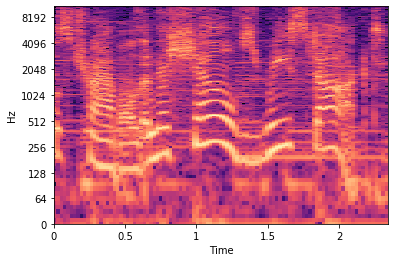

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


(20, 101) (1, 101)
(179, 101)
(101,)


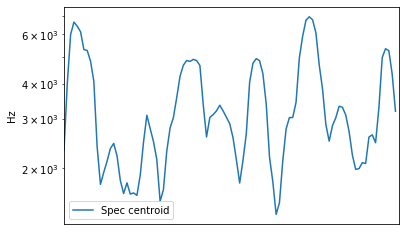

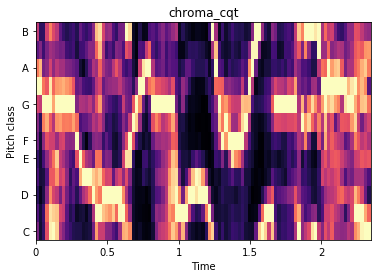

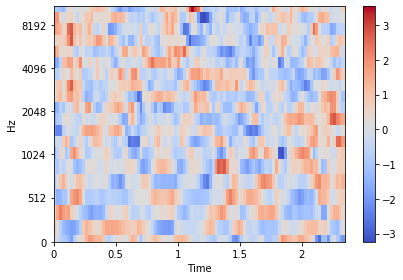

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


(20, 101) (1, 101)
len audio_sample_feats.shape: (179, 101)


KeyboardInterrupt: 

In [136]:
rad.predict_live(probs=False, onehot=False, lstm=True)

In [911]:
rad.predict_sample(audio[int(7.9 * 22050): int(12 * 22050)], lstm=True)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


(20, 177) (1, 177)
len audio_sample_feats.shape: (179, 177)


([array([[1., 0., 0.]], dtype=float32),
  array([[1., 0., 0.]], dtype=float32),
  array([[1., 0., 0.]], dtype=float32),
  array([[1., 0., 0.]], dtype=float32),
  array([[1., 0., 0.]], dtype=float32),
  array([[1., 0., 0.]], dtype=float32),
  array([[1., 0., 0.]], dtype=float32),
  array([[1., 0., 0.]], dtype=float32),
  array([[1., 0., 0.]], dtype=float32),
  array([[1., 0., 0.]], dtype=float32),
  array([[1., 0., 0.]], dtype=float32),
  array([[1., 0., 0.]], dtype=float32),
  array([[1., 0., 0.]], dtype=float32),
  array([[1., 0., 0.]], dtype=float32),
  array([[1., 0., 0.]], dtype=float32),
  array([[1., 0., 0.]], dtype=float32),
  array([[1., 0., 0.]], dtype=float32),
  array([[1., 0., 0.]], dtype=float32),
  array([[1., 0., 0.]], dtype=float32),
  array([[1., 0., 0.]], dtype=float32),
  array([[1., 0., 0.]], dtype=float32),
  array([[1., 0., 0.]], dtype=float32),
  array([[1., 0., 0.]], dtype=float32),
  array([[1., 0., 0.]], dtype=float32),
  array([[1., 0., 0.]], dtype=float32),


Notes:
    - radio announcers talk over quiet background music
    - can watch prediction probabilities while recording radio to maximize informativeness of samples; if error high, good to make an example featuring this type of audio
    
    references: https://www.kaggle.com/carlolepelaars/bidirectional-lstm-for-audio-labeling-with-keras - bidirectional lstm for audio labeling
    
    https://machinelearningmastery.com/develop-bidirectional-lstm-sequence-classification-python-keras/ - lstm tutorial
    
    https://wiki.aalto.fi/display/ITSP/ - zero crossing, deltas, cepstrum, mfcc
    
    https://musicinformationretrieval.com/mfcc.html - standardized mfcc's to have 0 mean and 1 std
    
    https://chrisalbon.com/deep_learning/keras/preprocessing_data_for_neural_networks/ - preprocessing
    
ideas:
    - baum-welch to tune my initial guess of HMM parameters?

In [241]:
ipd.Audio(audio[165000:180000], rate=22050)

In [ ]:
class AudioSource:
    def __init__(self, stream = False, content = None, buffer_length = None, sample_rate = 44100):
        self.stream = stream
        self.content = content
        self.buffer = None if self.buffer == None else [0] * sample_rate * buffer_length

    def sample(self, start_time = 0, end_time = -1):
        return self.content[start_time : end_time]
    
    def sample_iterator(self):
        last_t = time.time()
        t = 0
        t_gap = 40/1000 # 40 ms
        while True:
            if last_t - time.time() < t_gap: continue
            self.buffer = None #<- load in new contents here
            self.buffer *= self.volume
            yield t, buffer
    
    def play(self):
        for t, buf in sample_iterator(self):
            audiolibrary.play(buf)
    
    def mute(self):
        self.volume = 0
    
    def unmute(self):
        self.volume = 1
        
class RadioSource(AudioSource):
    def __init__(self, tuning_frequency = 88.3):
        super().__init__(stream = True, sample_rate)
        self.tuning_frequency = tuning_frequency # frequency in MHz
        

In [ ]:
class AdblockRadio():
    def __init__(self, SDR = None, radio_model = None):
        self.radio_model = radio_model(AudioSource(stream=True, content=SDR))
        self.play_filtered_stream()
    
    def play_filtered_stream(self):
        self.radio_model.radio_source.play()
        while True:
            self.radio_model.update_state()
            if self.radio_model.state == 1:
                self.radio_model.radio_source.mute()
            else:
                self.radio_model.radio_source.unmute()